# Predicting transcription factor-DNA binding from sequence

## Implementation

### Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os
from torch.utils.data import Dataset, DataLoader, random_split
#from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm, trange
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, normalize
import matplotlib.pyplot as plt
from Bio import SeqIO

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google'

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [46]:
# settings

data_path = "../data/"#"drive/My Drive/CS582/topic1-data/"
batch_size = 100
validation_ratio = 0.2

### Reading Transcription Factors

In [4]:
def get_tf_list(data_path):
  tf_list = os.listdir(data_path)
  for tf in tf_list:
      if not os.path.isdir(data_path+tf):
          tf_list.remove(tf)
  return tf_list

### Preprocessing & Reading Data

In [5]:
def one_hot_encoder(sequence):
   encoder = OneHotEncoder(sparse=False, dtype=int, handle_unknown='ignore')
   encoder.fit([['A'], ['T'], ['C'], ['G']])
   onehot_encoded = encoder.transform(sequence)
   return onehot_encoded

In [28]:
def read_pwms(data_path):
  pwm_list = []
  for file in os.listdir(data_path):
    if file.endswith(".wtmx"):
        pwm_list.append(data_path+file)
  print(pwm_list)
  pwm_matrices = [normalize(pd.read_csv(pwm, names = ['A', 'T', 'C', 'G'], sep="\t", header=None,
                          skiprows=1, skipfooter=1, dtype='float32', engine='python')
                          .to_numpy(), axis=1, norm='l1')
                          for pwm in pwm_list]
  return pwm_matrices

In [6]:
class TFBindingDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(TFBindingDataset, self).__init__()
        self.X = [np.array(list(record.seq.__str__().upper())).reshape(-1, 1) for record in SeqIO.parse(data_path, "fasta")]
        self.X = np.array([one_hot_encoder(data) for data in self.X]).astype('float32')
        shape = self.X.shape
        self.X = torch.as_tensor(self.X.reshape(shape[0], 1, shape[1], shape[2]))
        self.y = pd.read_csv(label_path, sep='\t', header=None).drop(labels=0, axis=1).to_numpy(dtype=float)

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

In [22]:
def get_symbol_ratio(sequence):
  seq_shape = sequence.shape
  atcg_ratio = np.sum(sequence, axis=0)/(seq_shape[0])
  return atcg_ratio

### Binding Histogram

In [7]:
def get_binding_values(train_loader, val_loader):
    binding_values = []
    for data in train_loader:
        _, y = data
        binding_values.extend(torch.reshape(y, (-1,)))
    for data in val_loader:
        _, y = data
        binding_values.extend(torch.reshape(y, (-1,)))
    return torch.stack(binding_values)

In [8]:
def plot_binding_histogram(data_loaders, data_name):
    binding_values = []
    for data_loader in data_loaders:
      for data in data_loader:
          _, y = data
          binding_values.extend(torch.reshape(y, (-1,)))
    binding_values = torch.stack(binding_values)
    plt.figure(figsize=(7,7))
    plt.title(data_name + " Bindings Histogram")
    plt.xlabel("Binding Value")
    plt.ylabel("Count")
    plt.hist(binding_values, bins=40)
    plt.show()

### Per-TF Model

In [9]:
class BindingPredictionCNN(Module):
    def __init__(self, drop_prob=0.3):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=10, kernel_size=(20, 4), stride=1)
        self.conv2 = Conv1d(in_channels=10, out_channels=20, kernel_size=14, stride=1)
        self.conv3 = Conv1d(in_channels=20, out_channels=30, kernel_size=10, stride=1)
        self.dropout = nn.Dropout(drop_prob)

        self.fc1 = Linear(in_features=30*105, out_features=1500)
        self.fc2 = Linear(in_features=1500, out_features=250)
        self.out = Linear(in_features=250, out_features=1)

    def forward(self, x):
        x = F.relu((self.conv1(x)).squeeze())
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

### Training & Testing

In [10]:
def train(net, train_loader, val_loader, optimizer, criterion, device, epoch_num=100):
    train_log = []
    val_log = []

    for epoch in range(1, epoch_num+1):
        train_loss = []
        net.train()
        for (x, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = net(x)
            loss = criterion(outputs.float(), y.float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))
        #print('============ epoch %d =============' %epoch)
        #print('train loss: %.3f' % np.mean(train_loss), flush=True, end='')

        test_loss = []
        net.eval()
        with torch.no_grad():
            for (x, y) in tqdm(val_loader, desc='Validation ', leave=False):
                x, y = x.to(device), y.to(device)
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())
                test_loss.append(loss.item())
        val_log.append(np.mean(test_loss))
        #print('validation loss: %.3f' % np.mean(test_loss), flush=True, end='')
    return train_log, val_log

In [11]:
def test(net, test_loader, device):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():
        for (x_input,labels) in tqdm(test_loader, desc='Test ', leave=False):
            x_input, labels = x_input.to(device), labels.to(device)
            outputs = net(x_input)
            y_true.extend(labels.float().detach().cpu().numpy())
            y_pred.extend(outputs.float().detach().cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

### Evaluation Metrics & Plots

In [12]:
def classification_statistics(y_true_binary, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print(confusion_matrix(y_true_binary, y_pred_binary))
    print(classification_report(y_true_binary, y_pred_binary))
    print("=== Statistics ===")
    print("Test Accuracy: %.3f" % accuracy)
    print("Test Sensitivity: %.3f" % sensitivity)
    print("Test Specificity: %.3f" % specificity)
    print("Test F1-Score: %.3f" % f1_score)
    return accuracy, sensitivity, specificity, f1_score

In [13]:
def plot_loss(axes, train_log, val_log, epoch_num, tf):
    #ace.figure(figsize=(7,7))
    axes.plot(range(1, epoch_num + 1), train_log, color='C0', label='training')
    axes.plot(range(1, epoch_num + 1), val_log, color='C1', label='validation')
    axes.set_title(tf)
    axes.set_xlabel('Epoch Number')
    axes.set_ylabel('MSE Loss')
    axes.legend(loc='best')

In [14]:
def roc_auc_curve_plot(y_true_binary, y_pred_binary, tf):
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
    auc = roc_auc_score(y_true_binary, y_pred_binary)
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr, label="auc="+str(auc))
    plt.title('ROC-AUC for Classification Task - ' + tf)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc='best')
    plt.legend()
    return auc

## Baseline

In [40]:
def get_max_llr_score(data_loader, pwm_matrices, atcg_ratio):
  max_llr_score = []
  for data in data_loader:
      X, _ = data 
      seq = X[0][0]
      max_score = torch.tensor(-float('inf'))
      for pwm in pwm_matrices:
        window_size = pwm.shape[0]
        w_base = torch.tile(torch.from_numpy(atcg_ratio), (window_size, 1))
        for i in range(seq.shape[0] - window_size+1):
            llr = torch.sum(torch.log(torch.max(torch.mul(torch.from_numpy(pwm), seq[i:i+window_size]), axis=1)[0])) - torch.sum(torch.log(torch.max(torch.mul(w_base, seq[i:i+window_size]), axis=1)[0]))
            max_score = torch.max(llr, max_score)
      max_llr_score.append(max_score.item())
  return max_llr_score

## Evaluation Baseline

In [24]:
tf_list = get_tf_list(data_path)

In [25]:
df_metrics = pd.DataFrame(columns=['Metric'] + tf_list)
df_metrics['Metric'] = ['Accuracy', 'Sensitivity', 'Specificity', 'F1_score', 'ROC-AUC']

In [26]:
df_metrics

Metric RUNX3 BATF MXI1 NFYB BCL3 ZEB1 PAX5 MEF2A TCF3  ... EBF1  \
0     Accuracy   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
1  Sensitivity   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
2  Specificity   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
3     F1_score   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
4      ROC-AUC   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   

  BHLHE40 IKZF1 RELA NFIC EGR1 USF2 ZNF143 TCF12 REST  
0     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  
1     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  
2     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  
3     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  
4     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  

[5 rows x 27 columns]

In [41]:
for i in range(5):
    for j in range(5):
        tf = tf_list[5*i+j]
        print("***************** " + tf + " *****************")
        train_data_path = data_path + tf + '/' + tf + '-train-sequence.fa'
        test_data_path = data_path + tf + '/' + tf + "-test-sequence.fa"
        train_label_path = data_path + tf + '/' + tf + "-train.bed"
        test_label_path = data_path + tf + '/' + tf + "-test.bed"
        pwm_path = data_path + tf + '/'

        pwm_matrices = read_pwms(pwm_path)

        train_set = TFBindingDataset(train_data_path, train_label_path) 
        test_set = TFBindingDataset(test_data_path, test_label_path)  

        train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
        test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)
        
        y_true_train = []
        y_true_test = []
        sequence = []

        for data in train_loader:
            X, y = data
            y_true_train.extend(torch.reshape(y, (-1,))) 
            sequence.extend(X[0][0])

        for data in test_loader:
            _, y = data
            y_true_test.extend(torch.reshape(y, (-1,))) 
        
        y_true_train = torch.stack(y_true_train)
        y_true_test = torch.stack(y_true_test)
        sequence = torch.stack(sequence)

        atcg_ratio = get_symbol_ratio(sequence.numpy())
        max_llr_score_train = get_max_llr_score(train_loader, pwm_matrices, atcg_ratio)
        max_llr_score_test = get_max_llr_score(test_loader, pwm_matrices, atcg_ratio)

        max_llr_threshold = np.median(max_llr_score_train)
        binding_threshold = np.median(y_true_train)

        max_llr_score_test_binary = (max_llr_score_test > max_llr_threshold)*1
        max_llr_score_train_binary = (max_llr_score_train > max_llr_threshold)*1
        y_true_test_binary = (y_true_test > binding_threshold)*1
        y_true_train_binary = (y_true_train > binding_threshold)*1
        
        print(y_true_test_binary)
        print(max_llr_score_test_binary)

        accuracy, sensitivity, specificity, f1_score = classification_statistics(y_true_test_binary, max_llr_score_test_binary)
        auc = roc_auc_score(y_true_test_binary, max_llr_score_test_binary)
        df_metrics[tf] = [accuracy, sensitivity, specificity, f1_score, auc]

***************** RUNX3 *****************
['../data/RUNX3/RUNX3_GM12878_1.wtmx', '../data/RUNX3/RUNX3_FB_1.wtmx', '../data/RUNX3/RUNX3_HOCO_C.wtmx', '../data/RUNX3/RUNX3_GM12878_2.wtmx', '../data/RUNX3/RUNX3_GM12878_3.wtmx', '../data/RUNX3/RUNX3_GM12878_4.wtmx', '../data/RUNX3/RUNX3_GM12878_5.wtmx']


KeyboardInterrupt: 

In [ ]:
df_metrics.to_csv('baseline.csv')

## Evaluation - Per-TF

In [42]:
tf_list = get_tf_list(data_path)
df_metrics = pd.DataFrame(columns=['Metric'] + tf_list)
df_metrics['Metric'] = ['Accuracy', 'Sensitivity', 'Specificity', 'F1_score', 'ROC-AUC']

In [43]:
df_metrics

Metric RUNX3 BATF MXI1 NFYB BCL3 ZEB1 PAX5 MEF2A TCF3  ... EBF1  \
0     Accuracy   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
1  Sensitivity   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
2  Specificity   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
3     F1_score   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
4      ROC-AUC   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   

  BHLHE40 IKZF1 RELA NFIC EGR1 USF2 ZNF143 TCF12 REST  
0     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  
1     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  
2     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  
3     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  
4     NaN   NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN  

[5 rows x 27 columns]

***************** RUNX3 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.51450104
0.661621
[[140  72]
 [ 88 100]]
              precision    recall  f1-score   support

           0       0.61      0.66      0.64       212
           1       0.58      0.53      0.56       188

    accuracy                           0.60       400
   macro avg       0.60      0.60      0.60       400
weighted avg       0.60      0.60      0.60       400

=== Statistics ===
Test Accuracy: 0.600
Test Sensitivity: 0.532
Test Specificity: 0.660
Test F1-Score: 0.556
***************** BATF *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.21260525
0.386426
[[ 75 119]
 [ 71 135]]
              precision    recall  f1-score   support

           0       0.51      0.39      0.44       194
           1       0.53      0.66      0.59       206

    accuracy                           0.53       400
   macro avg       0.52      0.52      0.51       400
weighted avg       0.52      0.53      0.52       400

=== Statistics ===
Test Accuracy: 0.525
Test Sensitivity: 0.655
Test Specificity: 0.387
Test F1-Score: 0.587
***************** MXI1 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  1564.9615
34.0
[[103 118]
 [ 53 126]]
              precision    recall  f1-score   support

           0       0.66      0.47      0.55       221
           1       0.52      0.70      0.60       179

    accuracy                           0.57       400
   macro avg       0.59      0.58      0.57       400
weighted avg       0.60      0.57      0.57       400

=== Statistics ===
Test Accuracy: 0.573
Test Sensitivity: 0.704
Test Specificity: 0.466
Test F1-Score: 0.596
***************** NFYB *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  42033.17
51.5
[[136 123]
 [ 58  83]]
              precision    recall  f1-score   support

           0       0.70      0.53      0.60       259
           1       0.40      0.59      0.48       141

    accuracy                           0.55       400
   macro avg       0.55      0.56      0.54       400
weighted avg       0.60      0.55      0.56       400

=== Statistics ===
Test Accuracy: 0.547
Test Sensitivity: 0.589
Test Specificity: 0.525
Test F1-Score: 0.478
***************** BCL3 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.16728635
0.49322449999999995
[[146  68]
 [ 71 115]]
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       214
           1       0.63      0.62      0.62       186

    accuracy                           0.65       400
   macro avg       0.65      0.65      0.65       400
weighted avg       0.65      0.65      0.65       400

=== Statistics ===
Test Accuracy: 0.652
Test Sensitivity: 0.618
Test Specificity: 0.682
Test F1-Score: 0.623
***************** ZEB1 *****************


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.2047574
0.5982274999999999
[[ 70 136]
 [ 74 120]]
              precision    recall  f1-score   support

           0       0.49      0.34      0.40       206
           1       0.47      0.62      0.53       194

    accuracy                           0.48       400
   macro avg       0.48      0.48      0.47       400
weighted avg       0.48      0.47      0.46       400

=== Statistics ===
Test Accuracy: 0.475
Test Sensitivity: 0.619
Test Specificity: 0.340
Test F1-Score: 0.533
***************** PAX5 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.13586949
0.374741
[[ 71 139]
 [ 75 115]]
              precision    recall  f1-score   support

           0       0.49      0.34      0.40       210
           1       0.45      0.61      0.52       190

    accuracy                           0.47       400
   macro avg       0.47      0.47      0.46       400
weighted avg       0.47      0.47      0.46       400

=== Statistics ===
Test Accuracy: 0.465
Test Sensitivity: 0.605
Test Specificity: 0.338
Test F1-Score: 0.518
***************** MEF2A *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.1505945
0.5808835
[[ 86  80]
 [ 64 170]]
              precision    recall  f1-score   support

           0       0.57      0.52      0.54       166
           1       0.68      0.73      0.70       234

    accuracy                           0.64       400
   macro avg       0.63      0.62      0.62       400
weighted avg       0.64      0.64      0.64       400

=== Statistics ===
Test Accuracy: 0.640
Test Sensitivity: 0.726
Test Specificity: 0.518
Test F1-Score: 0.702
***************** TCF3 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.26250353
0.4315965
[[104 103]
 [ 81 112]]
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       207
           1       0.52      0.58      0.55       193

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.54       400
weighted avg       0.54      0.54      0.54       400

=== Statistics ===
Test Accuracy: 0.540
Test Sensitivity: 0.580
Test Specificity: 0.502
Test F1-Score: 0.549
***************** SIN3A *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  305.5098
13.0
[[136  91]
 [ 62 111]]
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       227
           1       0.55      0.64      0.59       173

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.63      0.62      0.62       400

=== Statistics ===
Test Accuracy: 0.618
Test Sensitivity: 0.642
Test Specificity: 0.599
Test F1-Score: 0.592
***************** SPI1 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  1.9268091
0.8671785000000001
[[127  84]
 [ 86 103]]
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       211
           1       0.55      0.54      0.55       189

    accuracy                           0.57       400
   macro avg       0.57      0.57      0.57       400
weighted avg       0.57      0.57      0.57       400

=== Statistics ===
Test Accuracy: 0.575
Test Sensitivity: 0.545
Test Specificity: 0.602
Test F1-Score: 0.548
***************** USF1 *****************


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  1.5700498
0.5522805
[[127 128]
 [ 56  89]]
              precision    recall  f1-score   support

           0       0.69      0.50      0.58       255
           1       0.41      0.61      0.49       145

    accuracy                           0.54       400
   macro avg       0.55      0.56      0.54       400
weighted avg       0.59      0.54      0.55       400

=== Statistics ===
Test Accuracy: 0.540
Test Sensitivity: 0.614
Test Specificity: 0.498
Test F1-Score: 0.492
***************** MAX *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  966.86365
28.5
[[166  53]
 [ 63 118]]
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       219
           1       0.69      0.65      0.67       181

    accuracy                           0.71       400
   macro avg       0.71      0.70      0.71       400
weighted avg       0.71      0.71      0.71       400

=== Statistics ===
Test Accuracy: 0.710
Test Sensitivity: 0.652
Test Specificity: 0.758
Test F1-Score: 0.670
***************** NFATC1 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.06218998
0.23549150000000002
[[104  95]
 [ 88 113]]
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       199
           1       0.54      0.56      0.55       201

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.54       400
weighted avg       0.54      0.54      0.54       400

=== Statistics ===
Test Accuracy: 0.542
Test Sensitivity: 0.562
Test Specificity: 0.523
Test F1-Score: 0.553
***************** ELF1 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.18515629
0.4584785
[[ 85  95]
 [ 43 177]]
              precision    recall  f1-score   support

           0       0.66      0.47      0.55       180
           1       0.65      0.80      0.72       220

    accuracy                           0.66       400
   macro avg       0.66      0.64      0.64       400
weighted avg       0.66      0.66      0.64       400

=== Statistics ===
Test Accuracy: 0.655
Test Sensitivity: 0.805
Test Specificity: 0.472
Test F1-Score: 0.720
***************** YY1 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  4.7099414
0.7506285
[[ 67 178]
 [ 22 133]]
              precision    recall  f1-score   support

           0       0.75      0.27      0.40       245
           1       0.43      0.86      0.57       155

    accuracy                           0.50       400
   macro avg       0.59      0.57      0.49       400
weighted avg       0.63      0.50      0.47       400

=== Statistics ===
Test Accuracy: 0.500
Test Sensitivity: 0.858
Test Specificity: 0.273
Test F1-Score: 0.571
***************** EBF1 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  1.8710458
0.5562235
[[139 106]
 [ 71  84]]
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       245
           1       0.44      0.54      0.49       155

    accuracy                           0.56       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.58      0.56      0.56       400

=== Statistics ===
Test Accuracy: 0.557
Test Sensitivity: 0.542
Test Specificity: 0.567
Test F1-Score: 0.487
***************** BHLHE40 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  5552.9463
52.0
[[130 113]
 [ 55 102]]
              precision    recall  f1-score   support

           0       0.70      0.53      0.61       243
           1       0.47      0.65      0.55       157

    accuracy                           0.58       400
   macro avg       0.59      0.59      0.58       400
weighted avg       0.61      0.58      0.58       400

=== Statistics ===
Test Accuracy: 0.580
Test Sensitivity: 0.650
Test Specificity: 0.535
Test F1-Score: 0.548
***************** IKZF1 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  952.7367
27.0
[[149  95]
 [ 42 114]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.69       244
           1       0.55      0.73      0.62       156

    accuracy                           0.66       400
   macro avg       0.66      0.67      0.65       400
weighted avg       0.69      0.66      0.66       400

=== Statistics ===
Test Accuracy: 0.657
Test Sensitivity: 0.731
Test Specificity: 0.611
Test F1-Score: 0.625
***************** RELA *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  357.10388
13.899999999999999
[[153  93]
 [ 44 110]]
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       246
           1       0.54      0.71      0.62       154

    accuracy                           0.66       400
   macro avg       0.66      0.67      0.65       400
weighted avg       0.69      0.66      0.66       400

=== Statistics ===
Test Accuracy: 0.657
Test Sensitivity: 0.714
Test Specificity: 0.622
Test F1-Score: 0.616
***************** NFIC *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.09324778
0.344489
[[138  65]
 [ 72 125]]
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       203
           1       0.66      0.63      0.65       197

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.66      0.66      0.66       400

=== Statistics ===
Test Accuracy: 0.657
Test Sensitivity: 0.635
Test Specificity: 0.680
Test F1-Score: 0.646
***************** EGR1 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.4526373
0.476495
[[124  76]
 [ 54 146]]
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       200
           1       0.66      0.73      0.69       200

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.67       400
weighted avg       0.68      0.68      0.67       400

=== Statistics ===
Test Accuracy: 0.675
Test Sensitivity: 0.730
Test Specificity: 0.620
Test F1-Score: 0.692
***************** USF2 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  1309.0698
27.5
[[143  85]
 [ 76  96]]
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       228
           1       0.53      0.56      0.54       172

    accuracy                           0.60       400
   macro avg       0.59      0.59      0.59       400
weighted avg       0.60      0.60      0.60       400

=== Statistics ===
Test Accuracy: 0.598
Test Sensitivity: 0.558
Test Specificity: 0.627
Test F1-Score: 0.544
***************** ZNF143 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  174247.78
96.5
[[149  94]
 [ 57 100]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       243
           1       0.52      0.64      0.57       157

    accuracy                           0.62       400
   macro avg       0.62      0.63      0.62       400
weighted avg       0.64      0.62      0.63       400

=== Statistics ===
Test Accuracy: 0.623
Test Sensitivity: 0.637
Test Specificity: 0.613
Test F1-Score: 0.570
***************** TCF12 *****************


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.23533937
0.4062035
[[ 96 111]
 [ 66 127]]
              precision    recall  f1-score   support

           0       0.59      0.46      0.52       207
           1       0.53      0.66      0.59       193

    accuracy                           0.56       400
   macro avg       0.56      0.56      0.55       400
weighted avg       0.56      0.56      0.55       400

=== Statistics ===
Test Accuracy: 0.557
Test Sensitivity: 0.658
Test Specificity: 0.464
Test F1-Score: 0.589


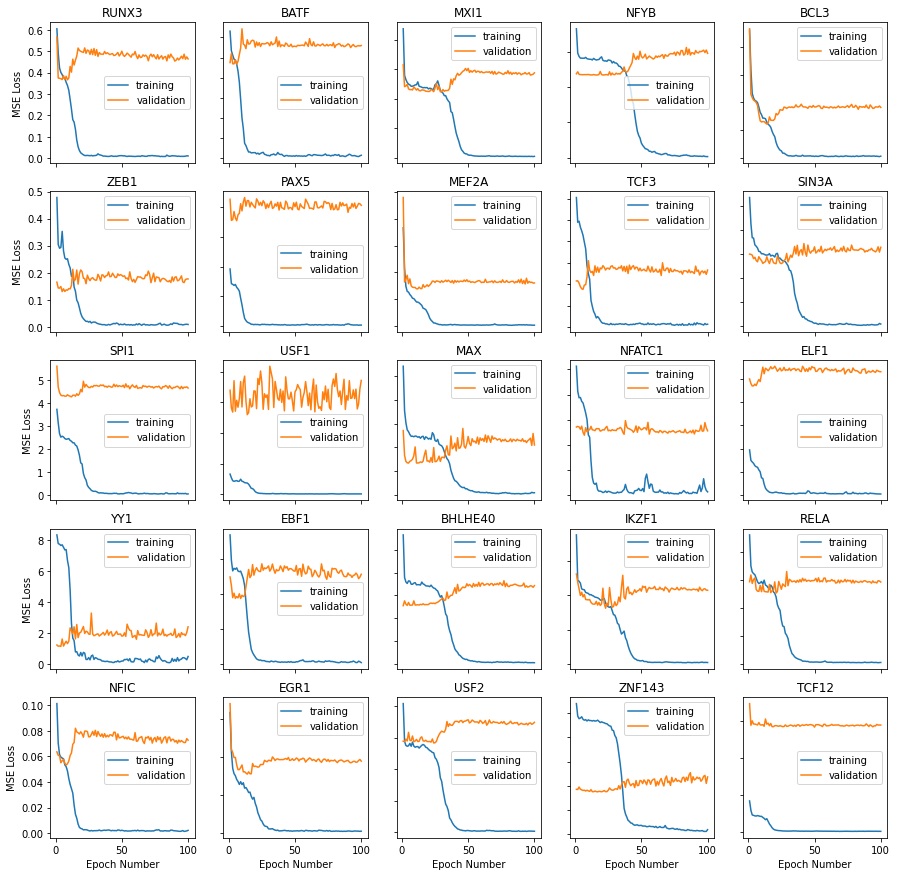

In [47]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))

for i in range(5):
    for j in range(5):
        tf = tf_list[5*i+j]
        print("***************** " + tf + " *****************")
        train_data_path = data_path + tf + '/' + tf + '-train-sequence.fa'
        test_data_path = data_path + tf + '/' + tf + "-test-sequence.fa"
        train_label_path = data_path + tf + '/' + tf + "-train.bed"
        test_label_path = data_path + tf + '/' + tf + "-test.bed"

        train_set = TFBindingDataset(train_data_path, train_label_path) 
        test_set = TFBindingDataset(test_data_path, test_label_path)  
        train_set, val_set = random_split(train_set, [int(len(train_set)) - int(len(train_set)*validation_ratio), int(len(train_set)*validation_ratio)])    

        train_loader = DataLoader(dataset=train_set,
                                batch_size=batch_size,
                                shuffle=True)
        val_loader = DataLoader(dataset=val_set,
                                batch_size=batch_size,
                                shuffle=True)
        test_loader = DataLoader(dataset=test_set,
                              batch_size=batch_size,
                              shuffle=True)

        model = BindingPredictionCNN()
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        #print(model)

        train_log, val_log = train(model, train_loader, val_loader, optimizer, criterion, device)
        plot_loss(axs[i, j], train_log, val_log, 100, tf)
        y_true, y_pred = test(model, test_loader, device)
        print("Test MSE: ", mean_squared_error(y_true, y_pred))

        #axs[i, j].plot(X[i], Y[j])
        #axs[i, j].set_title('Axis' + '[' + str(i) + ',' + str(j) + ']')

        #plot_binding_histogram([train_loader, val_loader], tf)
        binding_values = get_binding_values(train_loader, val_loader)
        binding_threshold = np.median(binding_values)
        print(binding_threshold)

        y_pred_binary = (y_pred > binding_threshold) * 1
        y_true_binary = (y_true > binding_threshold) * 1
        accuracy, sensitivity, specificity, f1_score = classification_statistics(y_true_binary, y_pred_binary)
        auc = roc_auc_score(y_true_binary,  y_pred_binary)
        df_metrics[tf] = [accuracy, sensitivity, specificity, f1_score, auc]
        
for ax in axs.flat:
    ax.label_outer()
    
plt.savefig('losses.pdf')

In [48]:
df_metrics.to_csv('per-tf.csv')

In [87]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [56]:
df_metrics.T.columns

RangeIndex(start=0, stop=5, step=1)

In [67]:
df_metrics.set_index('Metric').T.sort_values('F1_score', ascending=False)

Metric  Accuracy Sensitivity Specificity  F1_score   ROC-AUC
ELF1       0.655    0.804545    0.472222  0.719512  0.638384
MEF2A       0.64    0.726496    0.518072  0.702479  0.622284
EGR1       0.675        0.73        0.62  0.691943     0.675
MAX         0.71    0.651934    0.757991  0.670455  0.704962
NFIC      0.6575    0.634518    0.679803  0.645995   0.65716
IKZF1     0.6575    0.730769    0.610656  0.624658  0.670712
BCL3      0.6525     0.61828    0.682243  0.623306  0.650261
RELA      0.6575    0.714286    0.621951  0.616246  0.668118
MXI1      0.5725    0.703911    0.466063  0.595745  0.584987
SIN3A     0.6175    0.641618    0.599119     0.592  0.620369
TCF12     0.5575    0.658031    0.463768  0.589327    0.5609
BATF       0.525     0.65534    0.386598  0.586957  0.520969
YY1          0.5    0.858065    0.273469  0.570815  0.565767
ZNF143    0.6225    0.636943    0.613169  0.569801  0.625056
RUNX3        0.6    0.531915    0.660377  0.555556  0.596146
NFATC1    0.5425    0.562189    0.522613  0.552567  0.542401
TCF3        0.54    0.580311    0.502415   0.54902  0.541363
BHLHE40     0.58    0.649682    0.534979  0.548387   0.59233
SPI1       0.575    0.544974    0.601896  0.547872  0.573435
USF2      0.5975     0.55814    0.627193  0.543909  0.592666
ZEB1       0.475    0.618557    0.339806  0.533333  0.479181
PAX5       0.465    0.605263    0.338095  0.518018  0.471679
USF1        0.54    0.613793    0.498039  0.491713  0.555916
EBF1      0.5575    0.541935    0.567347  0.486957  0.554641
NFYB      0.5475    0.588652    0.525097  0.478386  0.556875
REST         NaN         NaN         NaN       NaN       NaN

In [88]:
df_metrics

Metric     RUNX3      BATF      MXI1      NFYB      BCL3      ZEB1  \
0     Accuracy  0.605000  0.555000  0.600000  0.495000  0.665000  0.507500   
1  Sensitivity  0.654255  0.470874  0.608939  0.567376  0.677419  0.649485   
2  Specificity  0.561321  0.644330  0.592760  0.455598  0.654206  0.373786   
3     F1_score  0.608911  0.521505  0.576720  0.441989  0.652850  0.561247   
4      ROC-AUC  0.511385  0.511385  0.511385  0.511385  0.511385  0.511385   

       PAX5     MEF2A      TCF3     SIN3A      SPI1      USF1       MAX  \
0  0.497500  0.700000  0.615000  0.630000  0.527500  0.565000  0.682500   
1  0.531579  0.752137  0.663212  0.739884  0.751323  0.475862  0.779006   
2  0.466667  0.626506  0.570048  0.546256  0.327014  0.615686  0.602740   
3  0.501241  0.745763  0.624390  0.633663  0.600423  0.442308  0.689487   
4  0.511385  0.511385  0.511385  0.511385  0.511385  0.511385  0.511385   

     NFATC1      ELF1       YY1      EBF1   BHLHE40     IKZF1      RELA  \
0  0.545000  0.622500  0.585000  0.532500  0.535000  0.632500  0.610000   
1  0.651741  0.690909  0.638710  0.683871  0.560510  0.698718  0.655844   
2  0.437186  0.538889  0.551020  0.436735  0.518519  0.590164  0.581301   
3  0.590090  0.668132  0.543956  0.531328  0.486188  0.597260  0.564246   
4  0.511385  0.511385  0.511385  0.511385  0.511385  0.511385  0.511385   

       NFIC      EGR1      USF2    ZNF143     TCF12 REST  
0  0.650000  0.705000  0.532500  0.650000  0.552500  NaN  
1  0.604061  0.760000  0.581395  0.643312  0.476684  NaN  
2  0.694581  0.650000  0.495614  0.654321  0.623188  NaN  
3  0.629630  0.720379  0.516796  0.590643  0.506887  NaN  
4  0.511385  0.511385  0.511385  0.511385  0.511385  NaN

In [68]:
df_metrics_baseline = pd.read_csv('baseline.csv')

In [72]:
df_metrics_baseline.columns

Index(['Unnamed: 0', 'Metric', 'TCF3', 'SIN3A', 'PAX5', 'BATF', 'BCL3',
       'RUNX3', 'MEF2A', 'ZEB1', 'MXI1', 'NFYB', 'IKZF1', 'YY1', 'SPI1',
       'RELA', 'NFATC1', 'USF1', 'ELF1', 'MAX', 'BHLHE40', 'EBF1', 'ZNF143',
       'USF2', 'NFIC', 'TCF12', 'REST', 'EGR1'],
      dtype='object')

In [73]:
df_metrics_baseline = df_metrics_baseline.drop(columns=['Unnamed: 0'])

In [75]:
df_metrics_baseline.set_index('Metric').T.sort_values('F1_score', ascending=False)

Metric   Accuracy  Sensitivity  Specificity  F1_score   ROC-AUC
NFIC       0.5250     0.543147     0.507389  0.529703  0.525268
MEF2A      0.5050     0.457265     0.572289  0.519417  0.514777
BATF       0.5150     0.490291     0.541237  0.510101  0.515764
MXI1       0.5275     0.547486     0.511312  0.509091  0.529399
MAX        0.5500     0.513812     0.579909  0.508197  0.546860
SPI1       0.5150     0.523810     0.507109  0.505102  0.515459
PAX5       0.5175     0.489474     0.542857  0.490765  0.516165
ELF1       0.5050     0.431818     0.594444  0.489691  0.513131
RUNX3      0.5000     0.500000     0.500000  0.484536  0.500000
NFATC1     0.4925     0.472637     0.512563  0.483461  0.492600
EBF1       0.5775     0.496774     0.628571  0.476780  0.562673
BHLHE40    0.4975     0.566879     0.452675  0.469657  0.509777
TCF12      0.5050     0.450777     0.555556  0.467742  0.503166
YY1        0.5550     0.490323     0.595918  0.460606  0.543120
BCL3       0.5125     0.424731     0.588785  0.447592  0.506758
SIN3A      0.4950     0.456647     0.524229  0.438889  0.490438
TCF3       0.4625     0.435233     0.487923  0.438642  0.461578
ZEB1       0.4650     0.417526     0.509709  0.430851  0.463617
USF2       0.4975     0.436047     0.543860  0.427350  0.489953
ZNF143     0.4875     0.477707     0.493827  0.422535  0.485767
RELA       0.5200     0.441558     0.569106  0.414634  0.505332
IKZF1      0.4975     0.455128     0.524590  0.413994  0.489859
USF1       0.5025     0.468966     0.521569  0.405970  0.495267
NFYB       0.5150     0.340426     0.610039  0.331034  0.475232
REST       0.5600     0.288732     0.709302  0.317829  0.499017
EGR1          NaN          NaN          NaN       NaN       NaN

In [86]:
df_metrics_model1 = pd.read_csv('statistics-m1.tsv', sep='\t')

In [87]:
df_metrics_model2 = pd.read_csv('statistics-m3.tsv', sep='\t')

In [89]:
df_metrics_model2.sort_values('F1 Score', ascending=False)

TF Name  Accuracy  Sensitivity  Specificity  F1 Score
0     MEF2A    0.6700     0.606061     0.701493  0.547945
17     PAX5    0.4850     0.442857     0.583333  0.546256
6       MAX    0.5650     0.505556     0.613636  0.511236
12    TCF12    0.5025     0.488152     0.518519  0.508642
5      ELF1    0.4175     0.396667     0.480000  0.505308
7   BHLHE40    0.5700     0.466667     0.642553  0.472393
20     USF2    0.4950     0.417910     0.572864  0.454054
25      YY1    0.5600     0.488722     0.595506  0.424837
21     ZEB1    0.5575     0.481481     0.596226  0.423453
23     TCF3    0.4850     0.393258     0.558559  0.404624
1     IKZF1    0.5200     0.426667     0.576000  0.400000
19     SPI1    0.4400     0.355769     0.531250  0.397849
16     NFIC    0.5350     0.424460     0.593870  0.388158
2      BCL3    0.4500     0.370968     0.518692  0.385475
14    SIN3A    0.5700     0.555556     0.573171  0.317460
8      MXI1    0.4900     0.439252     0.508532  0.315436
4      EBF1    0.5850     0.373737     0.654485  0.308333
18   NFATC1    0.5425     0.408163     0.586093  0.304183
22     USF1    0.5375     0.436782     0.565495  0.291188
13    RUNX3    0.5325     0.351852     0.599315  0.288973
3      BATF    0.5325     0.413793     0.565495  0.277992
24   ZNF143    0.5625     0.508475     0.571848  0.255319
11     RELA    0.5800     0.421053     0.606414  0.222222
9      EGR1    0.5700     0.363636     0.610778  0.218182
15     NFYB    0.5725     0.448980     0.589744  0.204651
10     REST    0.4800     0.513514     0.476584  0.154472

In [85]:
df_metrics_model1.sort_values('F1 Score', ascending=False)

TF Name  Accuracy  Sensitivity  Specificity  F1 Score
17     PAX5    0.4975     0.525000     0.433333  0.593939
5      ELF1    0.4950     0.453333     0.620000  0.573840
12    TCF12    0.5275     0.578199     0.470899  0.563510
0     MEF2A    0.6625     0.659091     0.664179  0.563107
6       MAX    0.5275     0.516667     0.536364  0.496000
2      BCL3    0.5150     0.478495     0.546729  0.478495
19     SPI1    0.5175     0.418269     0.625000  0.474114
7   BHLHE40    0.5150     0.503030     0.523404  0.461111
20     USF2    0.4775     0.412935     0.542714  0.442667
23     TCF3    0.4950     0.421348     0.554054  0.426136
21     ZEB1    0.5350     0.481481     0.562264  0.411392
1     IKZF1    0.4975     0.420000     0.544000  0.385321
16     NFIC    0.5075     0.431655     0.547893  0.378549
25      YY1    0.4950     0.458647     0.513109  0.376543
22     USF1    0.5350     0.517241     0.539936  0.326087
13    RUNX3    0.5075     0.416667     0.541096  0.313589
3      BATF    0.5500     0.459770     0.575080  0.307692
8      MXI1    0.4850     0.411215     0.511945  0.299320
18   NFATC1    0.5225     0.377551     0.569536  0.279245
4      EBF1    0.5225     0.333333     0.584718  0.256809
11     RELA    0.5425     0.508772     0.548105  0.240664
14    SIN3A    0.5325     0.402778     0.560976  0.236735
9      EGR1    0.5475     0.409091     0.574850  0.229787
24   ZNF143    0.4075     0.542373     0.384164  0.212625
15     NFYB    0.5375     0.428571     0.552707  0.185022
10     REST    0.4400     0.405405     0.443526  0.118110

In [67]:
df_metrics.set_index('Metric').T.sort_values('F1_score', ascending=False)

Metric  Accuracy Sensitivity Specificity  F1_score   ROC-AUC
ELF1       0.655    0.804545    0.472222  0.719512  0.638384
MEF2A       0.64    0.726496    0.518072  0.702479  0.622284
EGR1       0.675        0.73        0.62  0.691943     0.675
MAX         0.71    0.651934    0.757991  0.670455  0.704962
NFIC      0.6575    0.634518    0.679803  0.645995   0.65716
IKZF1     0.6575    0.730769    0.610656  0.624658  0.670712
BCL3      0.6525     0.61828    0.682243  0.623306  0.650261
RELA      0.6575    0.714286    0.621951  0.616246  0.668118
MXI1      0.5725    0.703911    0.466063  0.595745  0.584987
SIN3A     0.6175    0.641618    0.599119     0.592  0.620369
TCF12     0.5575    0.658031    0.463768  0.589327    0.5609
BATF       0.525     0.65534    0.386598  0.586957  0.520969
YY1          0.5    0.858065    0.273469  0.570815  0.565767
ZNF143    0.6225    0.636943    0.613169  0.569801  0.625056
RUNX3        0.6    0.531915    0.660377  0.555556  0.596146
NFATC1    0.5425    0.562189    0.522613  0.552567  0.542401
TCF3        0.54    0.580311    0.502415   0.54902  0.541363
BHLHE40     0.58    0.649682    0.534979  0.548387   0.59233
SPI1       0.575    0.544974    0.601896  0.547872  0.573435
USF2      0.5975     0.55814    0.627193  0.543909  0.592666
ZEB1       0.475    0.618557    0.339806  0.533333  0.479181
PAX5       0.465    0.605263    0.338095  0.518018  0.471679
USF1        0.54    0.613793    0.498039  0.491713  0.555916
EBF1      0.5575    0.541935    0.567347  0.486957  0.554641
NFYB      0.5475    0.588652    0.525097  0.478386  0.556875
REST         NaN         NaN         NaN       NaN       NaN

In [75]:
df_metrics_baseline.set_index('Metric').T.sort_values('F1_score', ascending=False)

Metric   Accuracy  Sensitivity  Specificity  F1_score   ROC-AUC
NFIC       0.5250     0.543147     0.507389  0.529703  0.525268
MEF2A      0.5050     0.457265     0.572289  0.519417  0.514777
BATF       0.5150     0.490291     0.541237  0.510101  0.515764
MXI1       0.5275     0.547486     0.511312  0.509091  0.529399
MAX        0.5500     0.513812     0.579909  0.508197  0.546860
SPI1       0.5150     0.523810     0.507109  0.505102  0.515459
PAX5       0.5175     0.489474     0.542857  0.490765  0.516165
ELF1       0.5050     0.431818     0.594444  0.489691  0.513131
RUNX3      0.5000     0.500000     0.500000  0.484536  0.500000
NFATC1     0.4925     0.472637     0.512563  0.483461  0.492600
EBF1       0.5775     0.496774     0.628571  0.476780  0.562673
BHLHE40    0.4975     0.566879     0.452675  0.469657  0.509777
TCF12      0.5050     0.450777     0.555556  0.467742  0.503166
YY1        0.5550     0.490323     0.595918  0.460606  0.543120
BCL3       0.5125     0.424731     0.588785  0.447592  0.506758
SIN3A      0.4950     0.456647     0.524229  0.438889  0.490438
TCF3       0.4625     0.435233     0.487923  0.438642  0.461578
ZEB1       0.4650     0.417526     0.509709  0.430851  0.463617
USF2       0.4975     0.436047     0.543860  0.427350  0.489953
ZNF143     0.4875     0.477707     0.493827  0.422535  0.485767
RELA       0.5200     0.441558     0.569106  0.414634  0.505332
IKZF1      0.4975     0.455128     0.524590  0.413994  0.489859
USF1       0.5025     0.468966     0.521569  0.405970  0.495267
NFYB       0.5150     0.340426     0.610039  0.331034  0.475232
REST       0.5600     0.288732     0.709302  0.317829  0.499017
EGR1          NaN          NaN          NaN       NaN       NaN

In [89]:
df_metrics_model2.sort_values('F1 Score', ascending=False)

TF Name  Accuracy  Sensitivity  Specificity  F1 Score
0     MEF2A    0.6700     0.606061     0.701493  0.547945
17     PAX5    0.4850     0.442857     0.583333  0.546256
6       MAX    0.5650     0.505556     0.613636  0.511236
12    TCF12    0.5025     0.488152     0.518519  0.508642
5      ELF1    0.4175     0.396667     0.480000  0.505308
7   BHLHE40    0.5700     0.466667     0.642553  0.472393
20     USF2    0.4950     0.417910     0.572864  0.454054
25      YY1    0.5600     0.488722     0.595506  0.424837
21     ZEB1    0.5575     0.481481     0.596226  0.423453
23     TCF3    0.4850     0.393258     0.558559  0.404624
1     IKZF1    0.5200     0.426667     0.576000  0.400000
19     SPI1    0.4400     0.355769     0.531250  0.397849
16     NFIC    0.5350     0.424460     0.593870  0.388158
2      BCL3    0.4500     0.370968     0.518692  0.385475
14    SIN3A    0.5700     0.555556     0.573171  0.317460
8      MXI1    0.4900     0.439252     0.508532  0.315436
4      EBF1    0.5850     0.373737     0.654485  0.308333
18   NFATC1    0.5425     0.408163     0.586093  0.304183
22     USF1    0.5375     0.436782     0.565495  0.291188
13    RUNX3    0.5325     0.351852     0.599315  0.288973
3      BATF    0.5325     0.413793     0.565495  0.277992
24   ZNF143    0.5625     0.508475     0.571848  0.255319
11     RELA    0.5800     0.421053     0.606414  0.222222
9      EGR1    0.5700     0.363636     0.610778  0.218182
15     NFYB    0.5725     0.448980     0.589744  0.204651
10     REST    0.4800     0.513514     0.476584  0.154472

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [110]:
accuracy = [["PAX5", "Multi-TF model-1", 0.4975],
          ["ELF1", "Multi-TF model-1", 0.4950],
          ["TCF12", "Multi-TF model-1", 0.5275],
          ["MEF2A", "Multi-TF model-1", 0.6625],
          ["MAX", "Multi-TF model-1", 0.5275],
          ["BCL3", "Multi-TF model-1", 0.5150],
          ["SPI1", "Multi-TF model-1", 0.5175],
          ["BHLHE40", "Multi-TF model-1", 0.5150],
          ["USF2", "Multi-TF model-1", 0.4775],
          ["TCF3", "Multi-TF model-1", 0.4950],
          ["ZEB1", "Multi-TF model-1", 0.5350],
          ["IKZF1", "Multi-TF model-1", 0.4975],
          ["NFIC", "Multi-TF model-1", 0.5075],
          ["YY1", "Multi-TF model-1", 0.4950],
          ["USF1", "Multi-TF model-1", 0.5350],
          ["RUNX3", "Multi-TF model-1", 0.5075],
          ["BATF", "Multi-TF model-1", 0.5500],
          ["MXI1", "Multi-TF model-1", 0.4850],
          ["NFATC1", "Multi-TF model-1", 0.5225],
          ["EBF1", "Multi-TF model-1", 0.5225],
          ["RELA", "Multi-TF model-1", 0.5425],
          ["SIN3A", "Multi-TF model-1", 0.5325],
          ["EGR1", "Multi-TF model-1", 0.5475],
          ["ZNF143", "Multi-TF model-1", 0.4075],
          ["NFYB", "Multi-TF model-1", 0.5375],
            ["PAX5", "Multi-TF model-2", 0.4850],
          ["ELF1", "Multi-TF model-2", 0.4175],
          ["TCF12", "Multi-TF model-2", 0.5025],
          ["MEF2A", "Multi-TF model-2", 0.6700],
          ["MAX", "Multi-TF model-2", 0.5650],
          ["BCL3", "Multi-TF model-2", 0.4500],
          ["SPI1", "Multi-TF model-2", 0.4400],
          ["BHLHE40", "Multi-TF model-2", 0.5700],
          ["USF2", "Multi-TF model-2", 0.4950],
          ["TCF3", "Multi-TF model-2", 0.4850],
          ["ZEB1", "Multi-TF model-2", 0.5575],
          ["IKZF1", "Multi-TF model-2", 0.5200],
          ["NFIC", "Multi-TF model-2", 0.5350],
          ["YY1", "Multi-TF model-2", 0.5600],
          ["USF1", "Multi-TF model-2", 0.5375],
          ["RUNX3", "Multi-TF model-2", 0.5325],
          ["BATF", "Multi-TF model-2", 0.5325],
          ["MXI1", "Multi-TF model-2", 0.4900],
          ["NFATC1", "Multi-TF model-2", 0.5425],
          ["EBF1", "Multi-TF model-2", 0.5850],
          ["RELA", "Multi-TF model-2", 0.5800],
          ["SIN3A", "Multi-TF model-2", 0.5700],
          ["EGR1", "Multi-TF model-2", 0.5700],
          ["ZNF143", "Multi-TF model-2", 0.5625],
          ["NFYB", "Multi-TF model-2", 0.5725],
           ["PAX5", "Per-TF model", 0.465],
          ["ELF1", "Per-TF model", 0.655],
          ["TCF12", "Per-TF model", 0.5575],
          ["MEF2A", "Per-TF model", 0.64],
          ["MAX", "Per-TF model", 0.71],
          ["BCL3", "Per-TF model", 0.6525],
          ["SPI1", "Per-TF model", 0.575],
          ["BHLHE40", "Per-TF model", 0.58],
          ["USF2", "Per-TF model", 0.5975],
          ["TCF3", "Per-TF model", 0.54],
          ["ZEB1", "Per-TF model", 0.475],
          ["IKZF1", "Per-TF model", 0.6575],
          ["NFIC", "Per-TF model", 0.6575],
          ["YY1", "Per-TF model", 0.5],
          ["USF1", "Per-TF model", 0.54],
          ["RUNX3", "Per-TF model", 0.6],
          ["BATF", "Per-TF model", 0.525],
          ["MXI1", "Per-TF model", 0.5725],
          ["NFATC1", "Per-TF model", 0.5425],
          ["EBF1", "Per-TF model", 0.5575],
          ["RELA", "Per-TF model", 0.6575],
          ["SIN3A", "Per-TF model", 0.6175],
          ["EGR1", "Per-TF model", 0.675],
          ["ZNF143", "Per-TF model", 0.6225],
          ["NFYB", "Per-TF model", 0.5475],
           ["PAX5", "Baseline", 0.5175],
          ["ELF1", "Baseline", 0.5050],
          ["TCF12", "Baseline", 0.5050],
          ["MEF2A", "Baseline", 0.5050],
          ["MAX", "Baseline", 0.5500],
          ["BCL3", "Baseline", 0.5125],
          ["SPI1", "Baseline", 0.5150],
          ["BHLHE40", "Baseline", 0.4975],
          ["USF2", "Baseline", 0.4975],
          ["TCF3", "Baseline", 0.4625],
          ["ZEB1", "Baseline", 0.4650],
          ["IKZF1", "Baseline", 0.4975],
          ["NFIC", "Baseline", 0.5250],
          ["YY1", "Baseline", 0.5550],
          ["USF1", "Baseline", 0.5025],
          ["RUNX3", "Baseline", 0.5000],
          ["BATF", "Baseline", 0.5150],
          ["MXI1", "Baseline", 0.5275],
          ["NFATC1", "Baseline", 0.4925],
          ["EBF1", "Baseline", 0.5775],
          ["RELA", "Baseline", 0.5200],
          ["SIN3A", "Baseline", 0.4950],
          ["EGR1", "Baseline", 0],
          ["ZNF143", "Baseline", 0.4875],
          ["NFYB", "Baseline", 0.5150]]

In [111]:
df = pd.DataFrame(accuracy, columns=["TF", "Method", "Accuracy"])

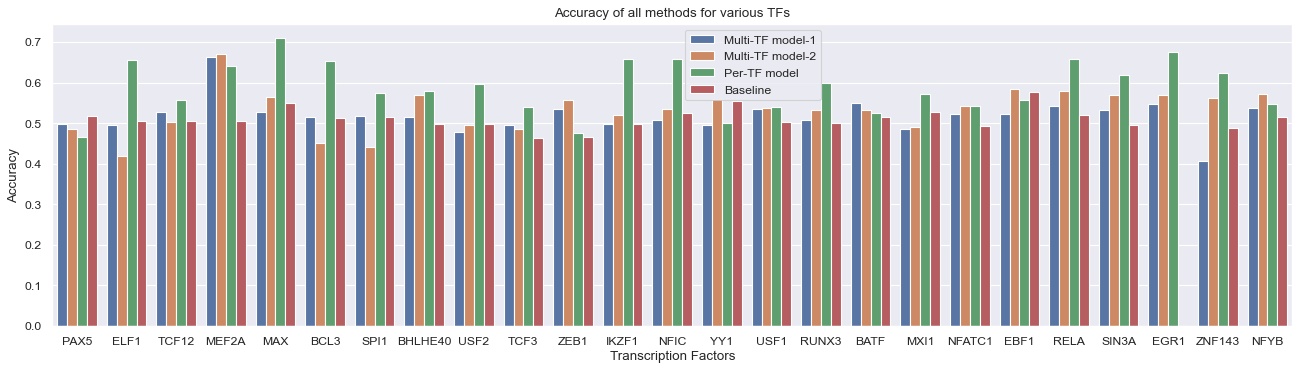

In [116]:
sns.set_theme()
fig = plt.figure(figsize=(20, 5), dpi=80)
ax = sns.barplot(x="TF", y="Accuracy", hue="Method", data=df)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Transcription Factors')
ax.legend(bbox_to_anchor=(0.51, 0.98), loc='upper left', borderaxespad=0)
ax.set_title('Accuracy of all methods for various TFs')
plt.savefig("acc.pdf", bbox_inches = 'tight')

In [78]:
df_metrics.T.columns

RangeIndex(start=0, stop=5, step=1)

In [80]:
new_header = df_metrics.T.iloc[0] 
df_metrics = df_metrics[1:]
df_metrics.columns = new_header 

In [16]:
tf = tf_list[4]

In [17]:
train_data_path = data_path + tf + '/' + tf + '-train-sequence.fa'
test_data_path = data_path + tf + '/' + tf + "-test-sequence.fa"
train_label_path = data_path + tf + '/' + tf + "-train.bed"
test_label_path = data_path + tf + '/' + tf + "-test.bed"

In [18]:
train_set = TFBindingDataset(train_data_path, train_label_path) 
test_set = TFBindingDataset(test_data_path, test_label_path)  
train_set, val_set = random_split(train_set, [int(len(train_set)) - int(len(train_set)*validation_ratio), int(len(train_set)*validation_ratio)])    

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)

In [19]:
for data in train_loader:
    X, y = data 
    print(X.shape)
    print(y.shape)
    break

torch.Size([100, 1, 501, 4])
torch.Size([100, 1])


In [22]:
model = BindingPredictionCNN()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


In [23]:
train_log, val_log = train(model, train_loader, val_loader, optimizer, criterion, device)

Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

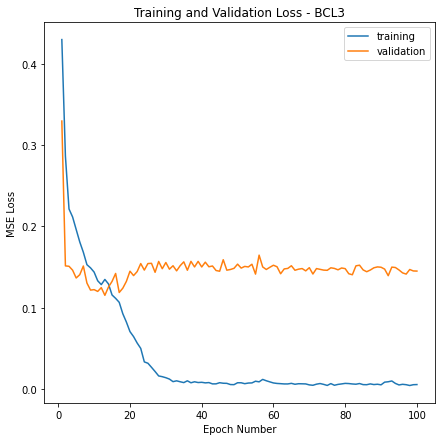

In [40]:
plot_loss(train_log, val_log, 100, tf)

In [24]:
y_true, y_pred = test(model, test_loader, device)

Test :   0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
print("Test MSE: ", mean_squared_error(y_true, y_pred))

Test MSE:  0.1465828


### Classification

In [27]:
binding_values = get_binding_values(train_loader, val_loader)

In [28]:
binding_threshold = np.median(binding_values)

In [29]:
binding_threshold

0.49322449999999995

In [30]:
y_pred_binary = (y_pred > binding_threshold) * 1
y_true_binary = (y_true > binding_threshold) * 1

In [31]:
classification_statistics(y_true_binary, y_pred_binary)

[[155  59]
 [ 50 136]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       214
           1       0.70      0.73      0.71       186

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400

=== Statistics ===
Test Accuracy: 0.728
Test Sensitivity: 0.731
Test Specificity: 0.724
Test F1-Score: 0.714


(0.7275, 0.7311827956989247, 0.7242990654205608, 0.7139107611548556)

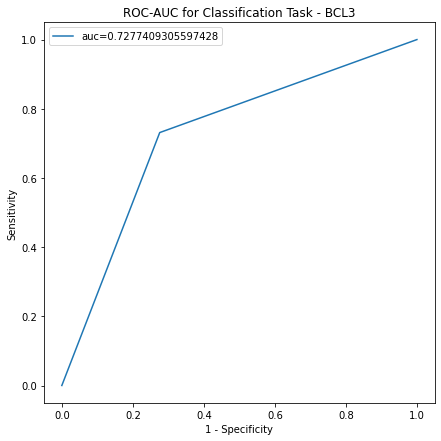

0.7277409305597428

In [32]:
roc_auc_curve_plot(y_true_binary,  y_pred_binary, tf)